In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

warnings.filterwarnings('ignore')

from datetime import date

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM, Dense, Dropout, Layer
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Preprocessing Part

In [2]:
start_date ='2000-02-01'
end_date = '2024-12-13'


In [3]:
def creating_features(data):
  data = data.copy()
  data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]
  data = data.filter(regex='^Close')
  #data['Date'] = data.index.date
  #data['Date'] = pd.to_datetime(data['Date'])
  return data

In [4]:
#Features_agglomorated
tickers = ['GC=F']

# Download historical data
features = yf.download(tickers, start= start_date, end=end_date, interval='1d')
#features = yf.download(tickers, end=end_date, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [5]:
final_data= creating_features(features).dropna()

In [6]:
final_data.shape

(6094, 1)

In [7]:
final_data.head(7)

,Close_GC=F
Date,
2000-08-30,273.899994
2000-08-31,278.299988
2000-09-01,277.000000
2000-09-05,275.799988
2000-09-06,274.200012
2000-09-07,274.000000
2000-09-08,273.299988


In [8]:
final_data.tail()

,Close_GC=F
Date,
2024-12-06,2638.600098
2024-12-09,2664.899902
2024-12-10,2697.600098
2024-12-11,2733.800049
2024-12-12,2687.500000


In [9]:
seq_length = 63

In [10]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:(i + seq_len)])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

In [11]:
def prepare_data(df, feature_column, seq_len=seq_length):
    data = df[feature_column].values.reshape(-1, 1)

    X, y = create_sequences(data, seq_len)

    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.2)

    X_train = X[:train_size]
    y_train = y[:train_size]

    X_val = X[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]

    X_test = X[train_size+val_size:]
    y_test = y[train_size+val_size:]

    scaler = MinMaxScaler()

    X_train_reshaped = X_train.reshape(-1, 1)
    scaler = scaler.fit(X_train_reshaped)

    X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    y_train_scaled = scaler.transform(y_train)
    y_val_scaled = scaler.transform(y_val)
    y_test_scaled = scaler.transform(y_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, scaler

In [12]:
def forecast_future(model, last_sequence, scaler, horizon):

    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(horizon):

        next_pred = model.predict(current_sequence.reshape(1, -1, 1), verbose=0)
        future_predictions.append(next_pred[0, 0])

        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred

    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)

    return future_predictions

In [13]:
class AttentionLayer(Layer):
   def __init__(self, **kwargs):
       super(AttentionLayer, self).__init__(**kwargs)

   def build(self, input_shape):
       self.W = self.add_weight(name='attention_weight',
                               shape=(input_shape[-1], 1),
                               initializer='random_normal',
                               trainable=True)
       self.b = self.add_weight(name='attention_bias',
                               shape=(input_shape[1], 1),
                               initializer='zeros',
                               trainable=True)

   def call(self, inputs):
       e = tf.tanh(tf.matmul(inputs, self.W) + self.b)
       a = tf.nn.softmax(e, axis=1)
       output = inputs * a
       return tf.reduce_sum(output, axis=1)

In [14]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        return inputs + delta

In [15]:
def lstm_trf(seq_len, features=1):

    model2 = Sequential([

        # First LSTM stack with residual connection
        ResidualWrapper(
            Sequential([
                Bidirectional(LSTM(128, activation='tanh', return_sequences=True,
                                 input_shape=(seq_len, features))),
                BatchNormalization(),
                Dropout(0.3)
            ])
        ),

        # Second LSTM stack
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
        BatchNormalization(),
        AttentionLayer(),
        Dropout(0.3),

        # Deeper dense layers with gradual dimension reduction
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.001)
    model2.compile(optimizer=optimizer,
                  loss='huber',
                  metrics=['mae', 'mse'])

    return model2,get_callbacks()

In [16]:
def get_callbacks():
    return [
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        )
    ]

In [17]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data(final_data, feature_column='Close_GC=F', seq_len=seq_length)

In [18]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((4221, 63, 1), (1206, 63, 1), (604, 63, 1), (4221, 1), (1206, 1), (604, 1))

In [19]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(factor=0.5, patience=5)


In [20]:
model_lstm_trf, callbacks = lstm_trf(seq_length)

In [21]:
history_lstm_trf = model_lstm_trf.fit(X_train, y_train,
                  epochs= 100,
                  batch_size=32,
                  validation_data=(X_val, y_val),
                  callbacks=[early_stopping, lr_reducer],
                  verbose=1)

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 54s 328ms/step - loss: 0.5003 - mae: 0.8712 - mse: 1.3147 - val_loss: 0.0305 - val_mae: 0.2059 - val_mse: 0.0609 - learning_rate: 0.0010
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 81s 323ms/step - loss: 0.1421 - mae: 0.4154 - mse: 0.2968 - val_loss: 0.0651 - val_mae: 0.3279 - val_mse: 0.1302 - learning_rate: 0.0010
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 84s 343ms/step - loss: 0.0734 - mae: 0.2880 - mse: 0.1506 - val_loss: 0.0441 - val_mae: 0.2589 - val_mse: 0.0882 - learning_rate: 0.0010
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 42s 321ms/step - loss: 0.0513 - mae: 0.2385 - mse: 0.1037 - val_loss: 0.0124 - val_mae: 0.1446 - val_mse: 0.0248 - learning_rate: 0.0010
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 82s 325ms/step - loss: 0.0308 - mae: 0.1843 - mse: 0.0618 - val_loss: 0.0041 - val_mae: 0.0850 - val_mse: 0.0083 - learning_rate: 0.0010
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 43s 325ms/step - loss: 0.0203 - mae: 0.1522 - mse: 0.0406 - val_loss:

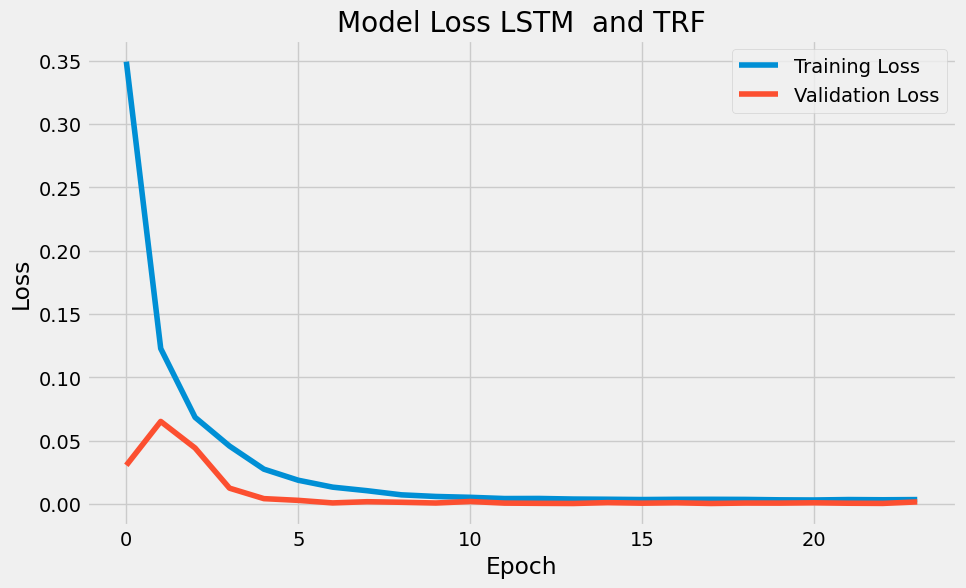

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(history_lstm_trf.history['loss'], label='Training Loss')
plt.plot(history_lstm_trf.history['val_loss'], label='Validation Loss')
plt.title('Model Loss LSTM  and TRF')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
#Predicting the price for a month in the horizon

horizon = 30

last_date = final_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=horizon, freq='B')
last_sequence = X_test[-1]

In [24]:
#Prediction using lstm and transformer
future_pred_lstm_trf = forecast_future(model_lstm_trf, last_sequence, scaler, horizon)

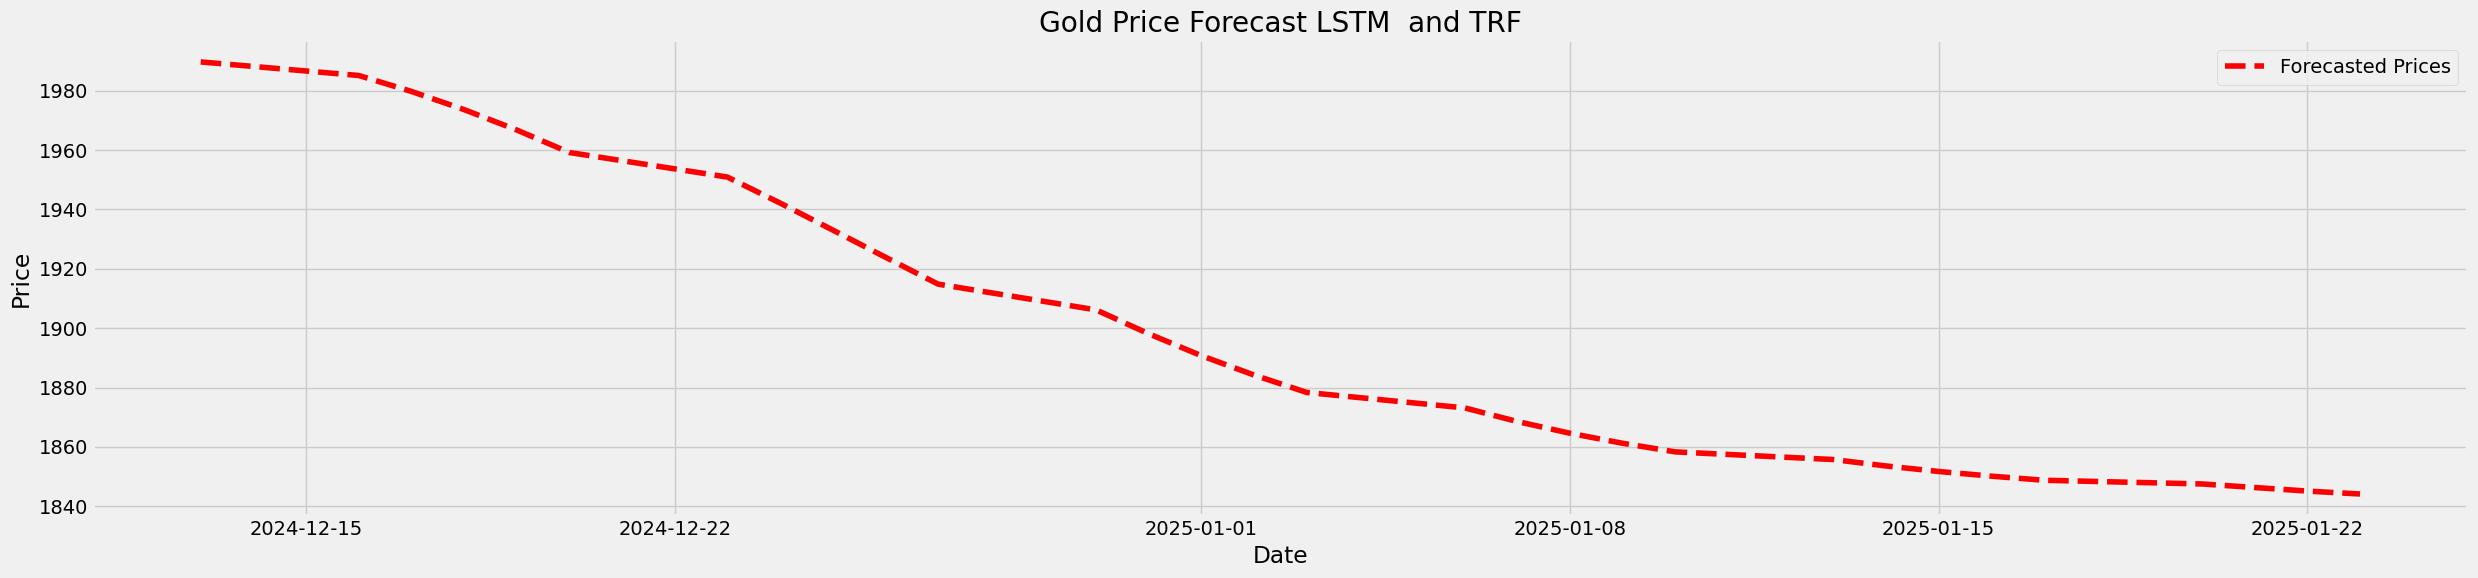

In [26]:
plt.figure(figsize=(25, 6))

#plt.plot(final_data.index[-15:], final_data['Close_GC=F'].values[-15:], label='Historical Prices', color='green')

plt.plot(future_dates, future_pred_lstm_trf, label='Forecasted Prices', linestyle='--', color= 'red')
plt.title('Gold Price Forecast LSTM  and TRF')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()